# Random Forest Algorithm

#### Importación de librerías ⬇️

In [28]:
import pickle
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import export_text, plot_tree
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor  # Asegúrate de importar DecisionTreeRegressor
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [24]:
# Importar data de un csv
data = pd.read_csv('los_data_gt.csv')
df = data.copy()
data

,dias_estancia,sexo,grupo_etnico,departamento,municipio,causa_atencion,condicion_egreso,tratamiento_recibido,edad_correcta,causa_categoria,edad_categoria,region
0,1.0,Hombre,Ignorado,Guatemala,San Juan Sacatepéquez,P95X,Vivo,Médico,0.000000,Certain conditions originating in the perinata...,Primera Infancia,Central
1,1.0,Mujer,Ignorado,Zacapa,Zacapa,P95X,Vivo,Médico,0.000000,Certain conditions originating in the perinata...,Primera Infancia,Nororiente
2,2.0,Mujer,No indígena,Quetzaltenango,Quetzaltenango,P95X,Vivo,Médico,0.000000,Certain conditions originating in the perinata...,Primera Infancia,Occidente
3,2.0,Mujer,No indígena,Quetzaltenango,Quetzaltenango,P95X,Vivo,Médico,0.000000,Certain conditions originating in the perinata...,Primera Infancia,Occidente
4,2.0,Mujer,No indígena,Quetzaltenango,Quetzaltenango,P95X,Vivo,Médico,0.000000,Certain conditions originating in the perinata...,Primera Infancia,Occidente
...,...,...,...,...,...,...,...,...,...,...,...,...
2228323,1.0,Mujer,"Mestizo, Ladino",Extranjero,Extranjero,O829,Vivo,Obstétrico,33.000000,"Pregnancy, childbirth and the puerperium",Adulto,Central
2228324,1.0,Mujer,"Mestizo, Ladino",Extranjero,Extranjero,O829,Vivo,Obstétrico,34.000000,"Pregnancy, childbirth and the puerperium",Adulto,Central
2228325,2.0,Mujer,"Mestizo, Ladino",Extranjero,Extranjero,O829,Vivo,Obstétrico,18.000000,"Pregnancy, childbirth and the puerperium",Adolescente,Central
2228326,3.0,Hombre,Maya,Guatemala,Guatemala,Z380,Vivo,Médico,0.008219,Factors influencing health status and contact ...,Primera Infancia,Central


# Preparaciones de la Data

In [25]:
df.pop('condicion_egreso')
df.pop('municipio')
df.pop('region')
df = df[df['departamento'] == 'Guatemala']
df.pop('departamento')

freqs = df['dias_estancia'].value_counts()
df = df.loc[df['dias_estancia'] <= 30]

# Filter out the rows where the frequency is not equal to 1
uniques = freqs[freqs == 1].index
df = df[~df['dias_estancia'].isin(uniques)]

# Define conditions for categorizing dias_estancia
conditions = [
    (df['dias_estancia'] < 5),
    (df['dias_estancia'] >= 5)
]

# Define labels for the categories
labels = [0, 1]

# Create a new column 'categoria_estancia' based on the conditions and labels
df['categoria_estancia'] = np.select(conditions, labels)

In [26]:
column_dtypes = df.dtypes

# Iterate through each column dtype and change dtype to "category" if it's "object"
for col_name, dtype in column_dtypes.items():
    if dtype == 'object':
        df[col_name] = df[col_name].astype('category')

df['categoria_estancia'] = df['categoria_estancia'].astype('category')

In [29]:
# Initialize the encoder
encoder = OrdinalEncoder()

# Reshape the input data to a 2-dimensional array
data = df[['causa_atencion']]  # Selecting only the column you want to encode
data = data.values.reshape(-1, 1)  # Reshape to a 2-dimensional array

# Fit and transform the encoder on the reshaped data
encoded_data = encoder.fit_transform(data)

# Assign the encoded data back to the DataFrame
df['causa_atencion'] = encoded_data

## Preparacion de las funciones de utilidad

In [82]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import time

def clfMetrics(clf, X_test, X_train, y_test, y_train):

    initTime = time.perf_counter()

    # Predecir en el conjunto de prueba
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    endTime = time.perf_counter()
    print(f"Se tardo {endTime - initTime} segundos en predecir")

    # Accuracy
    accuracy_test = accuracy_score(y_test, y_pred_test)
    accuracy_train = accuracy_score(y_train, y_pred_train)

    # Precision
    precision_test = precision_score(y_test, y_pred_test, average='micro')
    precision_train = precision_score(y_train, y_pred_train, average='micro')

    # Recall
    recall_test = recall_score(y_test, y_pred_test, average='micro')
    recall_train = recall_score(y_train, y_pred_train, average='micro')

    # F1 Score
    f1_test = f1_score(y_test, y_pred_test, average='micro')
    f1_train = f1_score(y_train, y_pred_train, average='micro')

    # Confusion Matrix
    confusionMatrix_test = confusion_matrix(y_test, y_pred_test)
    confusionMatrix_train = confusion_matrix(y_train, y_pred_train)

    print("--------------------------------------------------------------")
    print("----------------------------TEST------------------------------")

    # Calcular las matrices de confusión con porcentaje
    total_samples_test = np.sum(confusionMatrix_test)
    confusionMatrix_percent_test = confusionMatrix_test / total_samples_test * 100

    # Inicializar ConfusionMatrixDisplay con la matriz de confusión
    cmDisplay = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix_test)

    fig, ax = plt.subplots(figsize=(10, 10))

    # Plotting the confusion matrix
    cmDisplay.plot(ax=ax)
    plt.title('Matriz de Confusión de Modelo Clasificador')
    plt.show()

    # Inicializar ConfusionMatrixDisplay con la matriz de confusión porcentual
    cmDisplay = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix_percent_test)

    fig, ax = plt.subplots(figsize=(10, 10))

    # Plotting the confusion matrix
    cmDisplay.plot(ax=ax)
    plt.title('Matriz de Confusión de Modelo Clasificador (Porcentaje)')
    plt.show()

    print(confusionMatrix_percent_test)

    print("Accuracy:", accuracy_test)
    print("Precision:", precision_test)
    print("Recall:", recall_test)
    print("F1 Score:", f1_test)

    print("--------------------------------------------------------------")
    print("----------------------------TRAIN------------------------------")

    # Calcular las matrices de confusión con porcentaje
    total_samples_train = np.sum(confusionMatrix_train)
    confusionMatrix_percent_train = confusionMatrix_train / total_samples_train * 100

    # Inicializar ConfusionMatrixDisplay con la matriz de confusión
    cmDisplay = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix_train)

    fig, ax = plt.subplots(figsize=(10, 10))

    # Plotting the confusion matrix
    cmDisplay.plot(ax=ax)
    plt.title('Matriz de Confusión de Modelo Clasificador')
    plt.show()

    # Inicializar ConfusionMatrixDisplay con la matriz de confusión porcentual
    cmDisplay = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix_percent_train)

    fig, ax = plt.subplots(figsize=(10, 10))

    # Plotting the confusion matrix
    cmDisplay.plot(ax=ax)
    plt.title('Matriz de Confusión de Modelo Clasificador (Porcentaje)')
    plt.show()

    print(confusionMatrix_percent_train)

    print("Accuracy:", accuracy_train)
    print("Precision:", precision_train)
    print("Recall:", recall_train)
    print("F1 Score:", f1_train)


In [60]:
import time
def estMetrics(est, X_test,X_train , y_test,y_train):

    initTime = time.perf_counter()

    # Predecir en el conjunto de prueba
    y_pred_train = est.predict(X_train)
    y_pred_test = est.predict(X_test)
    endTime = time.perf_counter()
    print(f"Se tardo {endTime - initTime} segundos en predecir")

    # Calcular el error cuadrático medio
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    print("Error cuadrático medio en entrenamiento:", mse_train)
    print("Error cuadrático medio en prueba:", mse_test)

    # Calcular la raíz del error cuadrático medio
    rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
    rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
    print("Raíz del error cuadrático medio en entrenamiento:", rmse_train)
    print("Raíz del error cuadrático medio en prueba:", rmse_test)

    # Calcular el error absoluto medio
    rmse_train = mean_absolute_error(y_train, y_pred_train)
    rmse_test = mean_absolute_error(y_test, y_pred_test)
    print("El error absoluto medio en entrenamiento:", rmse_train)
    print("El error absoluto medio en prueba:", rmse_test)


    # Calcular el coeficiente de determinación
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    print("Coeficiente de determinación en entrenamiento:", r2_train)
    print("Coeficiente de determinación en prueba:", r2_test)

In [36]:
import time
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import plot_tree

from sklearn.model_selection import learning_curve

def regressionRandomForest(X_train, y_train, X_test, y_test, deep=None):
    # Crear el modelo de Random Forest
    rf_model = RandomForestRegressor(random_state=42, max_depth=deep)
    # Tunnear el modelo
    # rf_model = RandomForestRegressor(random_state=42)
    param_grid = {
         'n_estimators': [50, 100, 200, 300],
         'max_depth': [30, 35, 40, 45]
    }

    rt_tunned = GridSearchCV(rf_model, param_grid, cv=5, n_jobs=1)

    print('Entrenado el modelo...')
    # Entrenar el modelo
    rt_tunned.fit(X_train, y_train)
    print('Se entreno el modelo')

    # Obtener los mejores parametros
    print('Mejores parametros:', rt_tunned.best_params_)

    estMetrics(rt_tunned.best_estimator_, X_test,X_train , y_test,y_train)

    return rt_tunned



In [90]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score


def classificationRandomForest(X_train, y_train, X_test, y_test):
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 55, 40, 45, 30]
    }

    # Crear el modelo de Random Forest
    rf_model = RandomForestClassifier(random_state=42)

    # Crear el objeto GridSearchCV
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy')

    # Entrenar el modelo
    grid_search.fit(X_train, y_train)

    # Obtener los mejores parámetros y el mejor estimador
    best_params = grid_search.best_params_
    print("Los mejores parametros", best_params)
    best_estimator = grid_search.best_estimator_

    clfMetrics(best_estimator,X_test,X_train , y_test,y_train)

    return best_estimator

### Preparar los modelos de regresion

In [12]:
dr = data.copy()

In [54]:
# Evaluación de variables
def change(variable, dictValue, df2):
    count = 1

    def changeToVariable(x):
        nonlocal count
        nonlocal dictValue
        if x in dictValue:
            return dictValue[x]
        else:
            dictValue[x] = count
            count += 1
            return dictValue[x]
        
    if not pd.api.types.is_numeric_dtype(df2[variable]):
        df2[variable] = df2[variable].apply(changeToVariable)
    
        print(f'Para la variable {variable} los valores ahora son: ')
        for key, value in dictValue.items():
            print(key, ":", value)
    else:
        print(f"La columna {variable} es numerica")


def chageNotNumericVars(df):
    dicVars = {}
    for col in df.columns:
        change(col, dicVars, df)
    return dicVars

In [13]:
bestVals = dr['departamento'].value_counts()
dr = dr[dr['departamento'].isin(bestVals[:1].index)]
print(dr['departamento'].value_counts())
bestVals[:1]

departamento
Guatemala    1191647
Name: count, dtype: int64


departamento
Guatemala    1191647
Name: count, dtype: int64

In [14]:
y = dr.pop('dias_estancia')
dr.pop('condicion_egreso')
dr.pop('municipio')
dr.pop('departamento')
dr.pop('region')
x = dr
description = chageNotNumericVars(dr)

Para la variable sexo los valores ahora son: 
Hombre : 1
Mujer : 2
Para la variable grupo_etnico los valores ahora son: 
Hombre : 1
Mujer : 2
Ignorado : 1
No indígena : 2
Indígena : 3
Mestizo, Ladino : 4
Maya : 5
Otro : 6
Xinca : 7
Garífuna : 8
Para la variable causa_atencion los valores ahora son: 
Hombre : 1
Mujer : 2
Ignorado : 1
No indígena : 2
Indígena : 3
Mestizo, Ladino : 4
Maya : 5
Otro : 6
Xinca : 7
Garífuna : 8
P95X : 1
D251 : 2
D259 : 3
J039 : 4
J128 : 5
P369 : 6
Z380 : 7
A000 : 8
A010 : 9
A011 : 10
A020 : 11
A030 : 12
A039 : 13
A040 : 14
A047 : 15
A048 : 16
A049 : 17
A050 : 18
A053 : 19
A058 : 20
A059 : 21
A060 : 22
A064 : 23
A069 : 24
A071 : 25
A080 : 26
A084 : 27
A09X : 28
A162 : 29
A169 : 30
A180 : 31
A182 : 32
A239 : 33
A281 : 34
A309 : 35
A328 : 36
A329 : 37
A379 : 38
A38X : 39
A391 : 40
A412 : 41
A419 : 42
A448 : 43
A46X : 44
A499 : 45
A55X : 46
A600 : 47
A630 : 48
A64X : 49
A689 : 50
A699 : 51
A830 : 52
A86X : 53
A90X : 54
A91X : 55
A959 : 56
B001 : 57
B002 : 58
B009

In [18]:
# Separar los conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)

Tamaño del conjunto de entrenamiento: (953317, 7)
Tamaño del conjunto de prueba: (238330, 7)


Entrenado el modelo...
Se entreno el modelo
Se tardo 86.0478054999985 segundos en predecir
Error cuadrático medio en entrenamiento: 3.6513404467848014
Error cuadrático medio en prueba: 6.962202710570758
Raíz del error cuadrático medio en entrenamiento: 1.9108480962088015
Raíz del error cuadrático medio en prueba: 2.638598626273189
Coeficiente de determinación en entrenamiento: 0.473639344016754
Coeficiente de determinación en prueba: -0.006292129468866703


c:\Users\danar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\danar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


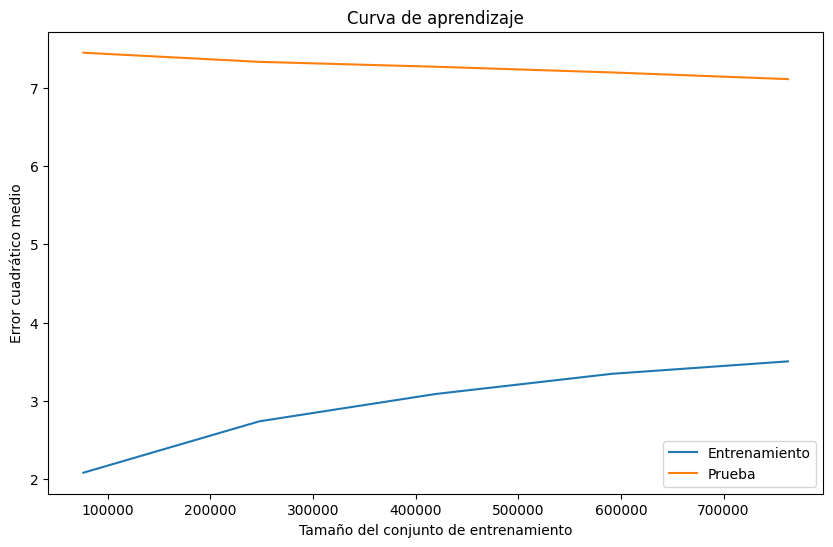

In [23]:
rmt_model = regressionRandomForest(X_train, y_train, X_test, y_test)

In [10]:
dr = data.copy()

In [11]:
bestVals = dr['departamento'].value_counts()
dr = dr[dr['departamento'].isin(bestVals[:1].index)]
print(dr['departamento'].value_counts())
bestVals[:1]

departamento
Guatemala    1191647
Name: count, dtype: int64


departamento
Guatemala    1191647
Name: count, dtype: int64

In [12]:
y = dr.pop('dias_estancia')
dr.pop('condicion_egreso')
dr.pop('municipio')
dr.pop('departamento')
dr.pop('region')
dr.pop('edad_correcta')
x = dr
description = chageNotNumericVars(dr)

Para la variable sexo los valores ahora son: 
Hombre : 1
Mujer : 2
Para la variable grupo_etnico los valores ahora son: 
Hombre : 1
Mujer : 2
Ignorado : 1
No indígena : 2
Indígena : 3
Mestizo, Ladino : 4
Maya : 5
Otro : 6
Xinca : 7
Garífuna : 8
Para la variable causa_atencion los valores ahora son: 
Hombre : 1
Mujer : 2
Ignorado : 1
No indígena : 2
Indígena : 3
Mestizo, Ladino : 4
Maya : 5
Otro : 6
Xinca : 7
Garífuna : 8
P95X : 1
D251 : 2
D259 : 3
J039 : 4
J128 : 5
P369 : 6
Z380 : 7
A000 : 8
A010 : 9
A011 : 10
A020 : 11
A030 : 12
A039 : 13
A040 : 14
A047 : 15
A048 : 16
A049 : 17
A050 : 18
A053 : 19
A058 : 20
A059 : 21
A060 : 22
A064 : 23
A069 : 24
A071 : 25
A080 : 26
A084 : 27
A09X : 28
A162 : 29
A169 : 30
A180 : 31
A182 : 32
A239 : 33
A281 : 34
A309 : 35
A328 : 36
A329 : 37
A379 : 38
A38X : 39
A391 : 40
A412 : 41
A419 : 42
A448 : 43
A46X : 44
A499 : 45
A55X : 46
A600 : 47
A630 : 48
A64X : 49
A689 : 50
A699 : 51
A830 : 52
A86X : 53
A90X : 54
A91X : 55
A959 : 56
B001 : 57
B002 : 58
B009

In [13]:
# Separar los conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)

Tamaño del conjunto de entrenamiento: (953317, 6)
Tamaño del conjunto de prueba: (238330, 6)


Entrenado el modelo...
Se entreno el modelo
La maxima profundidad del arbol es 49
Se tardo 29.61976980001782 segundos en predecir
Error cuadrático medio en entrenamiento: 5.28369125218198
Error cuadrático medio en prueba: 6.313362007497785
Raíz del error cuadrático medio en entrenamiento: 2.2986281239430575
Raíz del error cuadrático medio en prueba: 2.512640445327939
Coeficiente de determinación en entrenamiento: 0.2383270653492816
Coeficiente de determinación en prueba: 0.0874890084733021


c:\Users\danar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\danar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


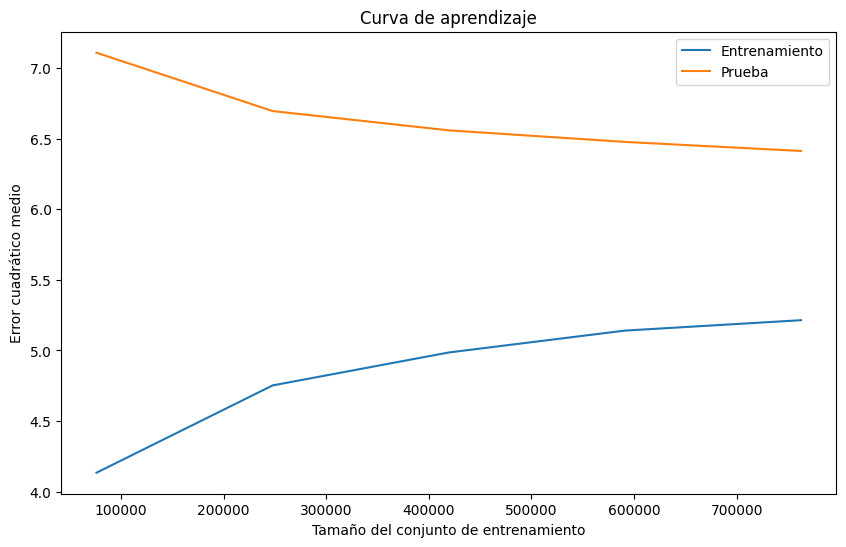

In [14]:
rmt_model2 = regressionRandomForest(X_train, y_train, X_test, y_test)

Entrenado el modelo...
Se entreno el modelo
La maxima profundidad del arbol es 40
Se tardo 19.29767170001287 segundos en predecir
Error cuadrático medio en entrenamiento: 5.28369311216969
Error cuadrático medio en prueba: 6.313240681239285
Raíz del error cuadrático medio en entrenamiento: 2.298628528529499
Raíz del error cuadrático medio en prueba: 2.512616302032462
Coeficiente de determinación en entrenamiento: 0.23832679722190053
Coeficiente de determinación en prueba: 0.08750654454113915


c:\Users\danar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\danar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


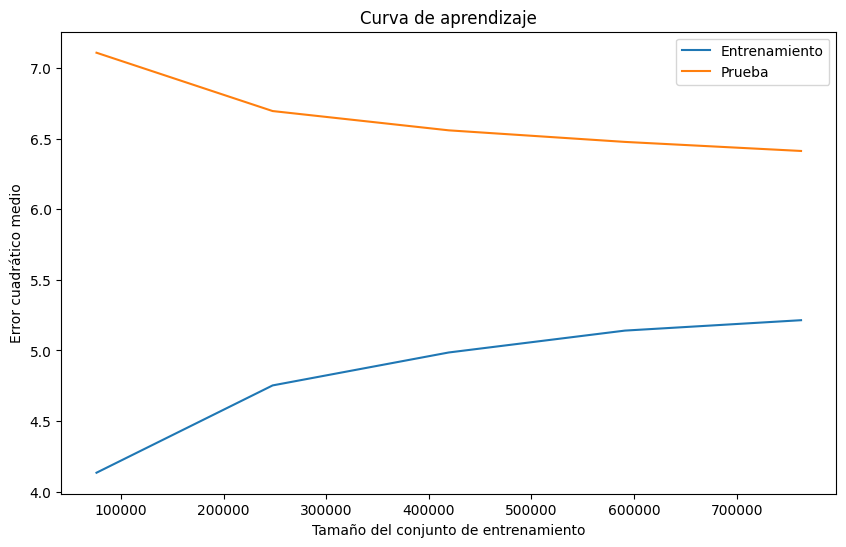

In [21]:
rmt_model2 = regressionRandomForest(X_train, y_train, X_test, y_test, deep=40)

Entrenado el modelo...
Se entreno el modelo
La maxima profundidad del arbol es 45
Se tardo 20.587188200006494 segundos en predecir
Error cuadrático medio en entrenamiento: 5.283688576351805
Error cuadrático medio en prueba: 6.313378180358824
Raíz del error cuadrático medio en entrenamiento: 2.298627541893598
Raíz del error cuadrático medio en prueba: 2.5126436636257883
Coeficiente de determinación en entrenamiento: 0.23832745108480713
Coeficiente de determinación en prueba: 0.0874866709052291


c:\Users\danar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\danar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


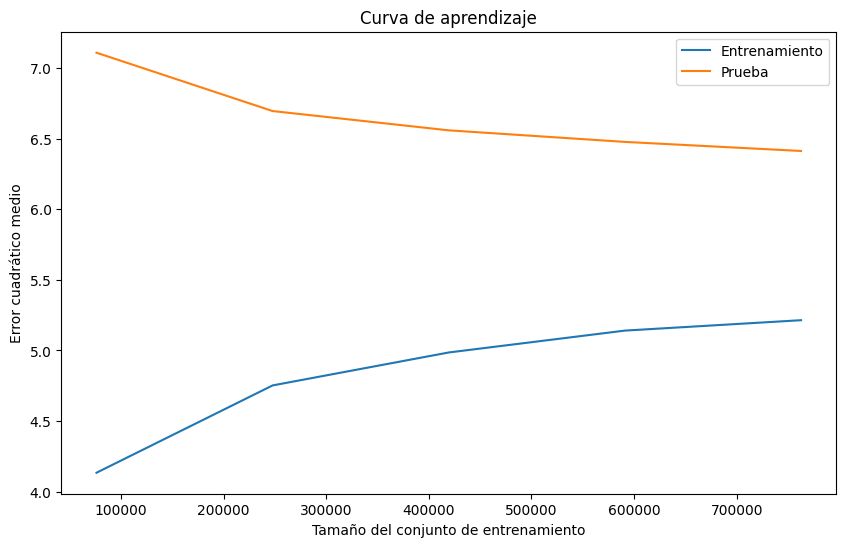

In [22]:
rmt_model2 = regressionRandomForest(X_train, y_train, X_test, y_test, deep=45)

In [6]:
df_cp = data.copy()
df_cp = df_cp[df_cp['grupo_etnico'] != 'Ignorado']
df_cp.pop('edad_correcta')
df_cp.pop('causa_atencion')


# Separate the target variable 'dias_estancia' into y and the rest of the DataFrame into X
y = df_cp.pop('dias_estancia')
description = chageNotNumericVars(df_cp)
X = df_cp

print(X.shape)
print(y.shape)

Para la variable sexo los valores ahora son: 
Mujer : 1
Hombre : 2
Para la variable grupo_etnico los valores ahora son: 
Mujer : 1
Hombre : 2
No indígena : 1
Indígena : 2
Mestizo, Ladino : 3
Maya : 4
Otro : 5
Xinca : 6
Garífuna : 7
Para la variable departamento los valores ahora son: 
Mujer : 1
Hombre : 2
No indígena : 1
Indígena : 2
Mestizo, Ladino : 3
Maya : 4
Otro : 5
Xinca : 6
Garífuna : 7
Quetzaltenango : 1
Jutiapa : 2
Guatemala : 3
El progreso : 4
Izabal : 5
Peten : 6
Huehuetenango : 7
Quiché : 8
Santa Rosa : 9
Jalapa : 10
Chimaltenango : 11
Totonicapán : 12
Extranjero : 13
Retalhuleu : 14
Suchitepéquez : 15
Baja Verapaz : 16
Escuintla : 17
Zacapa : 18
San Marcos : 19
Sololá : 20
Sacatepequez : 21
Chiquimula : 22
Alta Verapaz : 23
Para la variable municipio los valores ahora son: 
Mujer : 1
Hombre : 2
No indígena : 1
Indígena : 2
Mestizo, Ladino : 3
Maya : 4
Otro : 5
Xinca : 6
Garífuna : 7
Quetzaltenango : 1
Jutiapa : 2
Guatemala : 3
El progreso : 4
Izabal : 5
Peten : 6
Huehueten

In [7]:
# Separar los conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)

Tamaño del conjunto de entrenamiento: (1143249, 9)
Tamaño del conjunto de prueba: (285813, 9)


In [8]:
rmt_model3 = regressionRandomForest(X_train, y_train, X_test, y_test, deep=45)

Entrenado el modelo...
Se entreno el modelo
Mejores parametros: {'max_depth': 10, 'n_estimators': 300}
Se tardo 33.15377869999793 segundos en predecir
Error cuadrático medio en entrenamiento: 6.305107810072698
Error cuadrático medio en prueba: 6.450007725237242
Raíz del error cuadrático medio en entrenamiento: 2.5109973735694546
Raíz del error cuadrático medio en prueba: 2.5396865407442
Coeficiente de determinación en entrenamiento: 0.09352958395971311
Coeficiente de determinación en prueba: 0.08318110716421556


c:\Users\danar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\danar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [13]:
# Importar modelo a un pickle
with open('rmt_model3.pkl', 'wb') as f:
    pickle.dump(rmt_model3, f)

rmt_model3

GridSearchCV(cv=5,
             estimator=RandomForestRegressor(max_depth=45, random_state=42),
             n_jobs=1,
             param_grid={'max_depth': [5, 10, 15, 45],
                         'n_estimators': [50, 100, 200, 300]})

In [5]:
df_cp = data.copy()
df_cp = df_cp[df_cp['grupo_etnico'] != 'Ignorado']
# Solo dejar los datos del departamento con mas registros
bestDep = df_cp['departamento'].value_counts()
df_cp = df_cp[df_cp['departamento'].isin(bestDep[:1].index)]


df_cp.pop('edad_correcta')
df_cp.pop('causa_atencion')
df_cp.pop('condicion_egreso')
df_cp.pop('departamento')
df_cp.pop('region')
df_cp.pop('municipio')


# Separate the target variable 'dias_estancia' into y and the rest of the DataFrame into X
y = df_cp.pop('dias_estancia')
description = chageNotNumericVars(df_cp)
X = df_cp

print(X.shape)
print(y.shape)

Para la variable sexo los valores ahora son: 
Mujer : 1
Hombre : 2
Para la variable grupo_etnico los valores ahora son: 
Mujer : 1
Hombre : 2
No indígena : 1
Indígena : 2
Mestizo, Ladino : 3
Maya : 4
Otro : 5
Xinca : 6
Garífuna : 7
Para la variable tratamiento_recibido los valores ahora son: 
Mujer : 1
Hombre : 2
No indígena : 1
Indígena : 2
Mestizo, Ladino : 3
Maya : 4
Otro : 5
Xinca : 6
Garífuna : 7
Médico : 1
Cirugía : 2
Obstétrico : 3
Para la variable causa_categoria los valores ahora son: 
Mujer : 1
Hombre : 2
No indígena : 1
Indígena : 2
Mestizo, Ladino : 3
Maya : 4
Otro : 5
Xinca : 6
Garífuna : 7
Médico : 1
Cirugía : 2
Obstétrico : 3
Certain conditions originating in the perinatal period : 1
Certain infectious and parasitic diseases : 2
Neoplasms : 3
Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism : 4
Endocrine, nutritional and metabolic diseases : 5
Mental, Behavioral and Neurodevelopmental disorders : 6
Diseases of the nervou

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)

Tamaño del conjunto de entrenamiento: (461060, 5)
Tamaño del conjunto de prueba: (115266, 5)


In [11]:
rtFTunned = regressionRandomForest(X_train, y_train, X_test, y_test, deep=45)

Entrenado el modelo...
Se entreno el modelo
Mejores parametros: {'max_depth': 10, 'n_estimators': 300}
Se tardo 17.406132400006754 segundos en predecir
Error cuadrático medio en entrenamiento: 7.697192595889843
Error cuadrático medio en prueba: 7.471762886715143
Raíz del error cuadrático medio en entrenamiento: 2.774381479877964
Raíz del error cuadrático medio en prueba: 2.733452557977757
Coeficiente de determinación en entrenamiento: 0.10306896182088288
Coeficiente de determinación en prueba: 0.0997759351930213


c:\Users\danar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\danar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [8]:
# Crear y entrenar un modelo random Forest
rtF = RandomForestRegressor(random_state=42)
rtF.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [10]:
# Predecir en el conjunto de prueba
initTime = time.perf_counter()
y_pred_train = rtF.predict(X_train)
y_pred_test = rtF.predict(X_test)
endTime = time.perf_counter()
print(f"Se tardo {endTime - initTime} segundos en predecir")

# Calcular el error cuadrático medio
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
print("Error cuadrático medio en entrenamiento:", mse_train)
print("Error cuadrático medio en prueba:", mse_test)

# Calcular la raíz del error cuadrático medio
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print("Raíz del error cuadrático medio en entrenamiento:", rmse_train)
print("Raíz del error cuadrático medio en prueba:", rmse_test)

# Calcular el coeficiente de determinación
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
print("Coeficiente de determinación en entrenamiento:", r2_train)
print("Coeficiente de determinación en prueba:", r2_test)

Se tardo 6.726232100001653 segundos en predecir
Error cuadrático medio en entrenamiento: 7.680337449860198
Error cuadrático medio en prueba: 7.473364923886961
Raíz del error cuadrático medio en entrenamiento: 2.7713421748063154
Raíz del error cuadrático medio en prueba: 2.733745585069496
Coeficiente de determinación en entrenamiento: 0.10503304202787977
Coeficiente de determinación en prueba: 0.09958291616435944


c:\Users\danar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\danar\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Se realiza los modelos de clasificacion

In [46]:
df.columns

Index(['dias_estancia', 'sexo', 'grupo_etnico', 'causa_atencion',
       'tratamiento_recibido', 'edad_correcta', 'causa_categoria',
       'edad_categoria', 'categoria_estancia'],
      dtype='object')

In [64]:
# Usar el SOMTEEN
from imblearn.combine import SMOTEENN
# Crear una instancia de RandomUnderSampler
rus = SMOTEENN(random_state=42)

dfClassifier = df.copy()


In [65]:
dfClassifier.pop('causa_categoria')
dfClassifier.pop('dias_estancia')
dfClassifier.pop('edad_correcta')
0

0

In [66]:
y = dfClassifier.pop('categoria_estancia')
X = dfClassifier
chageNotNumericVars(X)

Para la variable sexo los valores ahora son: 
Hombre : 1
Mujer : 2
Para la variable grupo_etnico los valores ahora son: 
Hombre : 1
Mujer : 2
Garífuna : 1
Ignorado : 2
Indígena : 3
Maya : 4
Mestizo, Ladino : 5
No indígena : 6
Otro : 7
Xinca : 8
La columna causa_atencion es numerica
Para la variable tratamiento_recibido los valores ahora son: 
Hombre : 1
Mujer : 2
Garífuna : 1
Ignorado : 2
Indígena : 3
Maya : 4
Mestizo, Ladino : 5
No indígena : 6
Otro : 7
Xinca : 8
Cirugía : 1
Médico : 2
Obstétrico : 3
Para la variable edad_categoria los valores ahora son: 
Hombre : 1
Mujer : 2
Garífuna : 1
Ignorado : 2
Indígena : 3
Maya : 4
Mestizo, Ladino : 5
No indígena : 6
Otro : 7
Xinca : 8
Cirugía : 1
Médico : 2
Obstétrico : 3
Adolescente : 1
Adulto : 2
Juventud : 3
Persona Mayor : 4
Primera Infancia : 5
Segunda Infancia : 6


{'Hombre': 1,
 'Mujer': 2,
 'Garífuna': 1,
 'Ignorado': 2,
 'Indígena': 3,
 'Maya': 4,
 'Mestizo, Ladino': 5,
 'No indígena': 6,
 'Otro': 7,
 'Xinca': 8,
 'Cirugía': 1,
 'Médico': 2,
 'Obstétrico': 3,
 'Adolescente': 1,
 'Adulto': 2,
 'Juventud': 3,
 'Persona Mayor': 4,
 'Primera Infancia': 5,
 'Segunda Infancia': 6}

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)

Tamaño del conjunto de entrenamiento: (952109, 5)
Tamaño del conjunto de prueba: (238028, 5)


In [85]:
# Hacer un Random Forest como clasificador
rfClass_model = RandomForestClassifier(random_state=42)
rfClass_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Se tardo 27.691172399994684 segundos en predecir
--------------------------------------------------------------
----------------------------TEST------------------------------


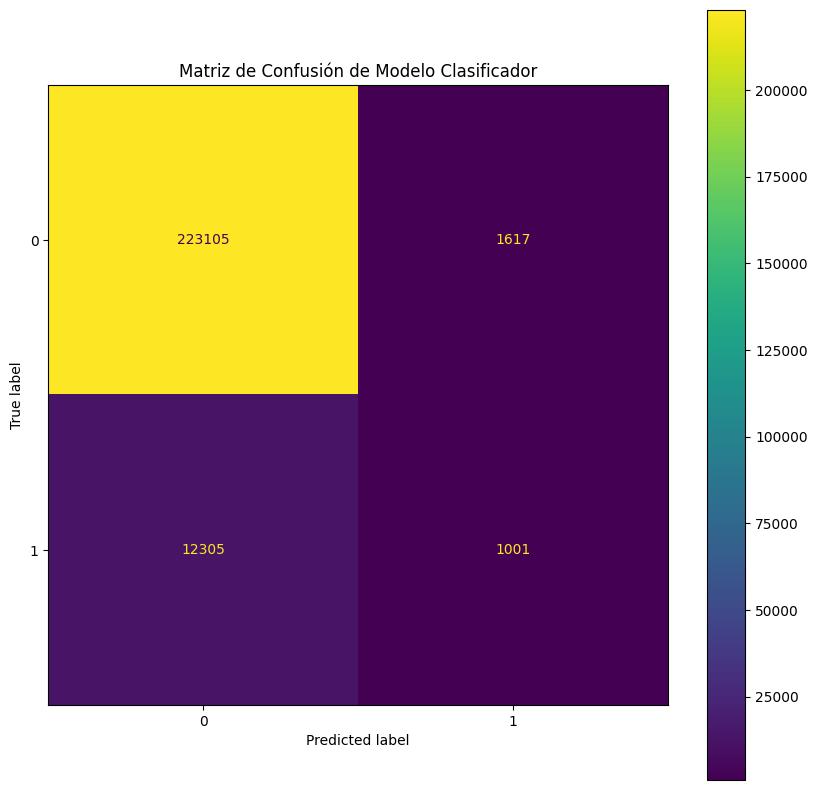

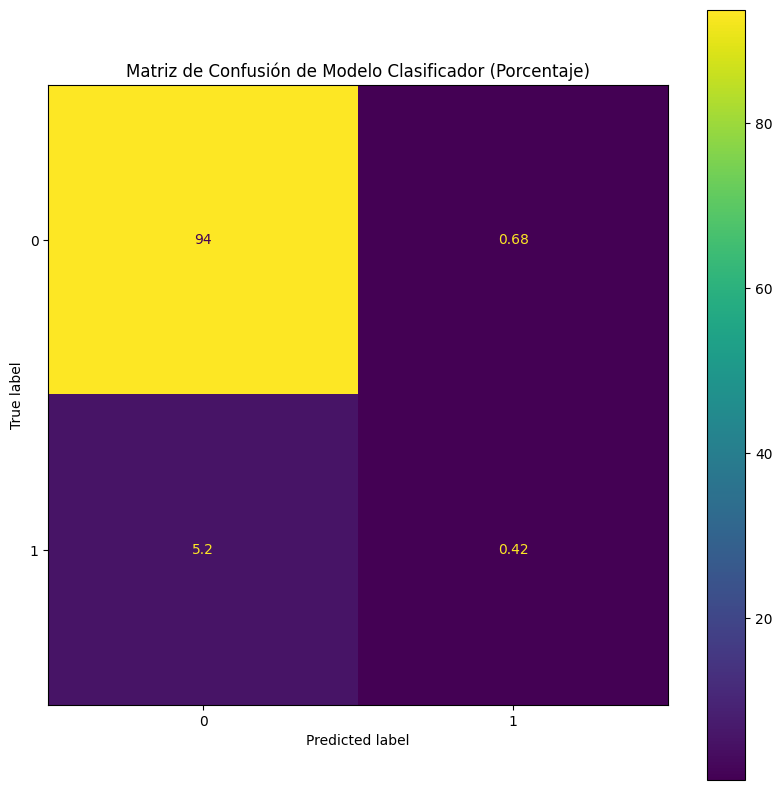

[[93.73056951  0.67933184]
 [ 5.16955988  0.42053876]]
Accuracy: 0.9415110827297629
Precision: 0.9415110827297629
Recall: 0.9415110827297629
F1 Score: 0.9415110827297629
--------------------------------------------------------------
----------------------------TRAIN------------------------------


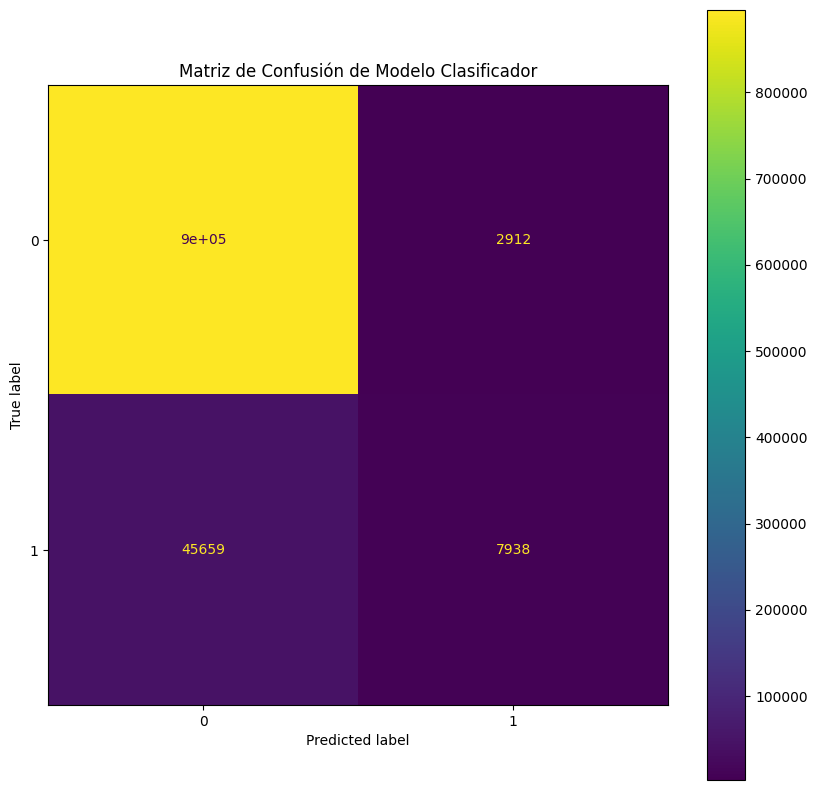

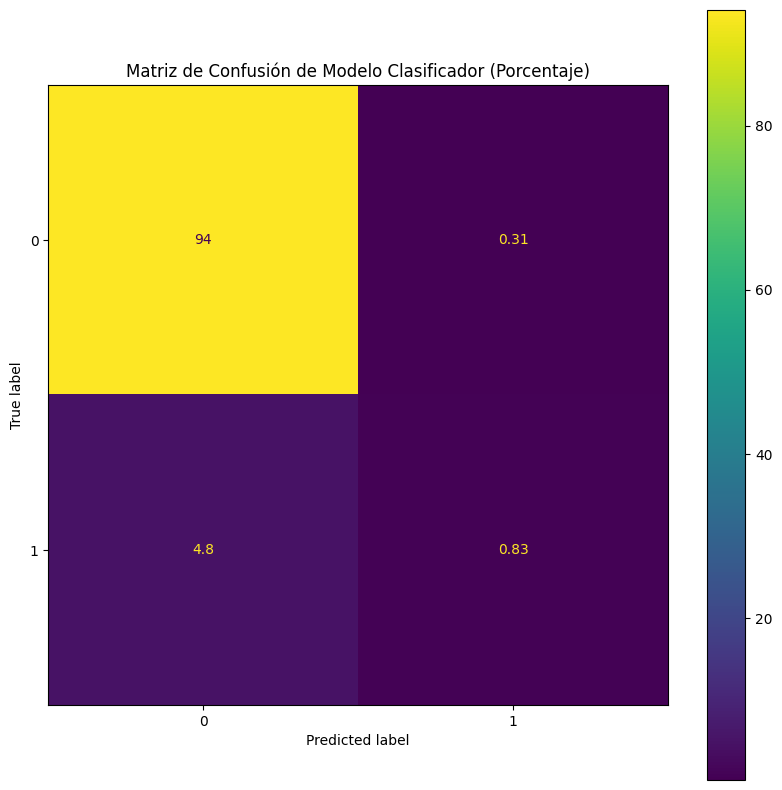

[[94.06486022  0.30584733]
 [ 4.79556437  0.83372807]]
Accuracy: 0.9489858829188674
Precision: 0.9489858829188674
Recall: 0.9489858829188674
F1 Score: 0.9489858829188674


In [86]:
clfMetrics(rfClass_model, X_test,X_train , y_test,y_train)

In [67]:
# Aplicar RandomUnderSampler a tus datos
X_resampled, y_resampled = rus.fit_resample(X, y)

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)

Tamaño del conjunto de entrenamiento: (1001417, 5)
Tamaño del conjunto de prueba: (250355, 5)


In [69]:
# Hacer un Random Forest como clasificador
rfClass_model = RandomForestClassifier(random_state=42)
rfClass_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [74]:
max([estimator.tree_.max_depth for estimator in rfClass_model.estimators_])

55

Se tardo 11.432497999980114 segundos en predecir
--------------------------------------------------------------
----------------------------TEST------------------------------


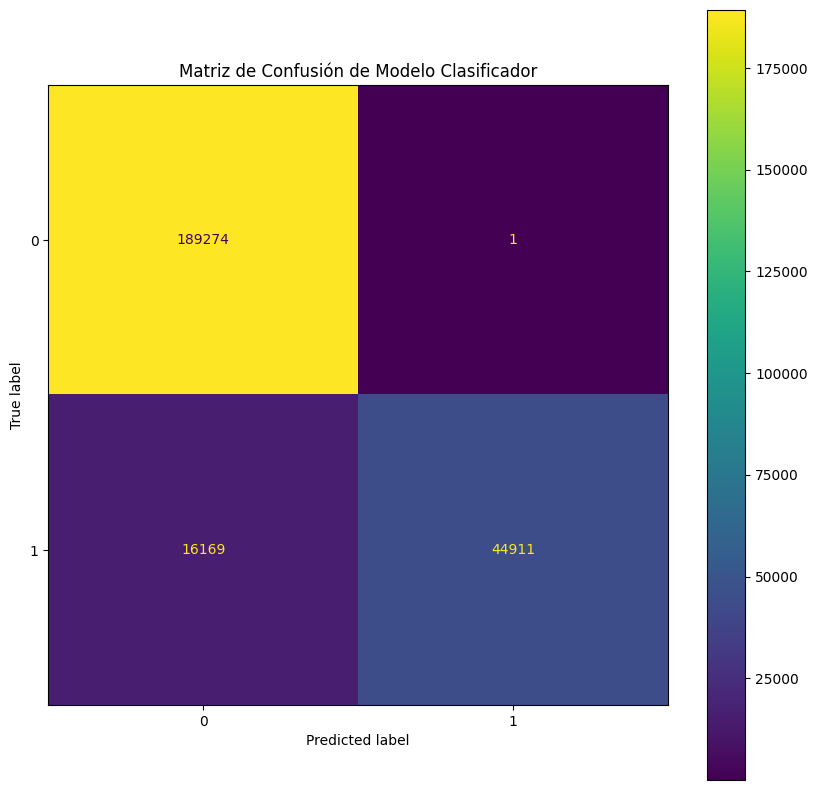

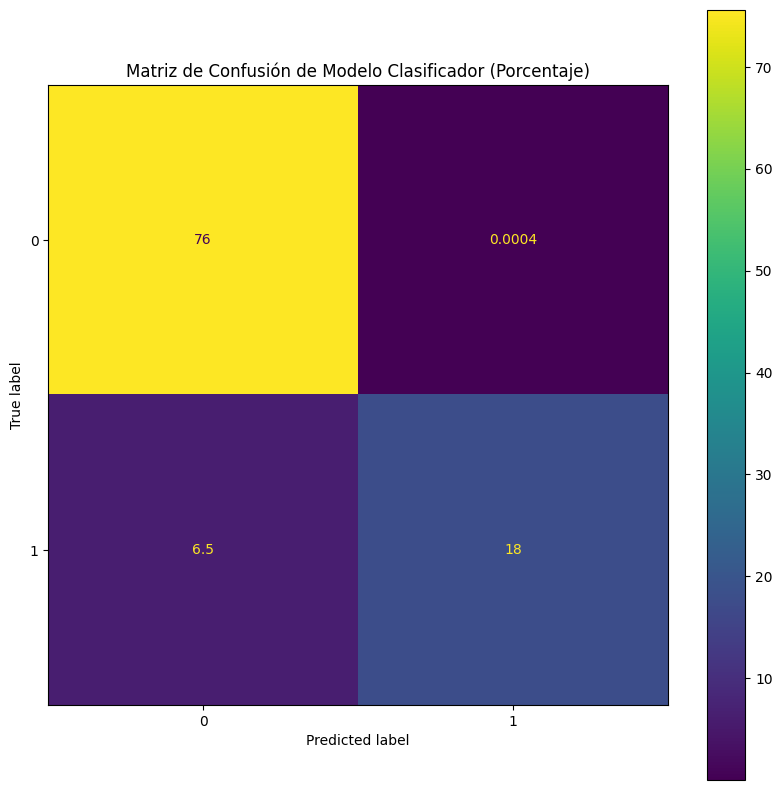

[[7.56022448e+01 3.99432805e-04]
 [6.45842903e+00 1.79389267e+01]]
Accuracy: 0.9354117153641829
Precision: 0.9354117153641829
Recall: 0.9354117153641829
F1 Score: 0.9354117153641829
--------------------------------------------------------------
----------------------------TRAIN------------------------------


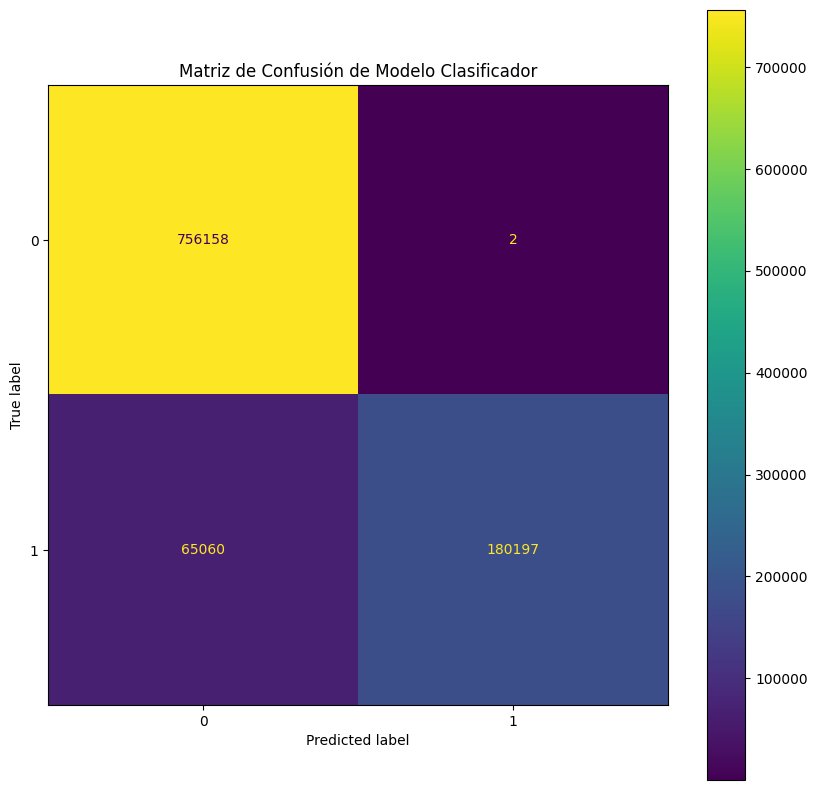

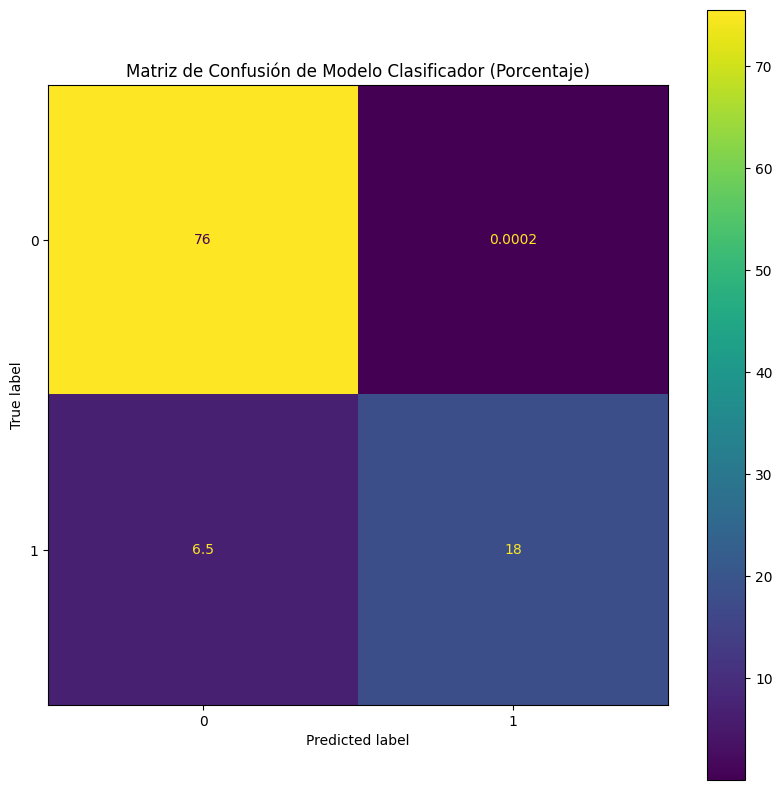

[[7.55088040e+01 1.99717001e-04]
 [6.49679404e+00 1.79942022e+01]]
Accuracy: 0.9350300624015769
Precision: 0.9350300624015769
Recall: 0.9350300624015769
F1 Score: 0.9350300624015769


In [83]:
clfMetrics(rfClass_model, X_test,X_train , y_test,y_train)

### Tuneamos el mejor modelo de clasificacion

Los mejores parametros {'max_depth': 40, 'n_estimators': 200}
Se tardo 16.91108059999533 segundos en predecir
--------------------------------------------------------------
----------------------------TEST------------------------------


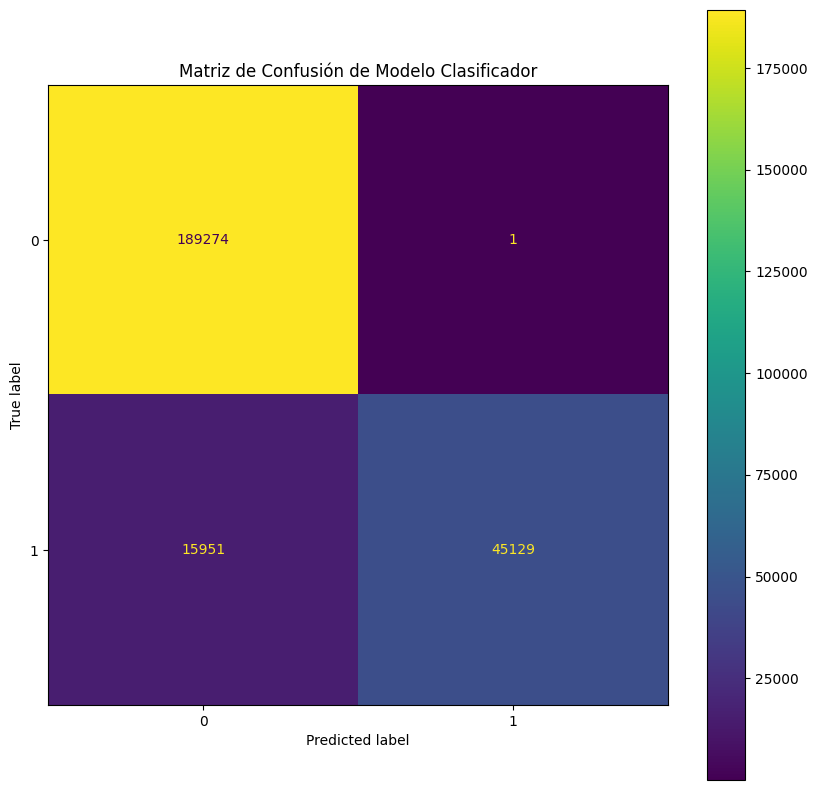

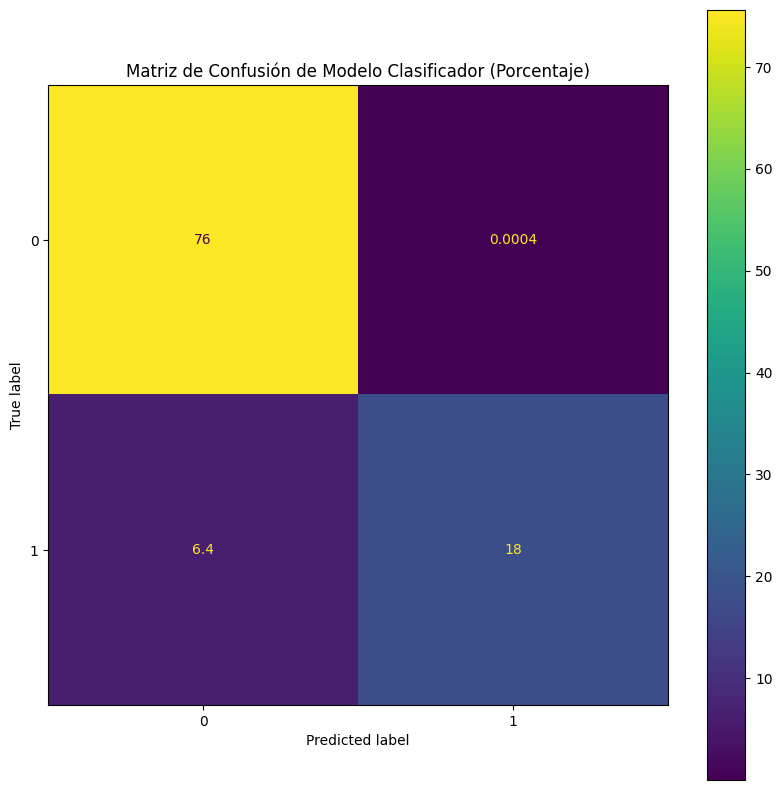

[[7.56022448e+01 3.99432805e-04]
 [6.37135268e+00 1.80260031e+01]]
Accuracy: 0.9362824788799904
Precision: 0.9362824788799904
Recall: 0.9362824788799904
F1 Score: 0.9362824788799904
--------------------------------------------------------------
----------------------------TRAIN------------------------------


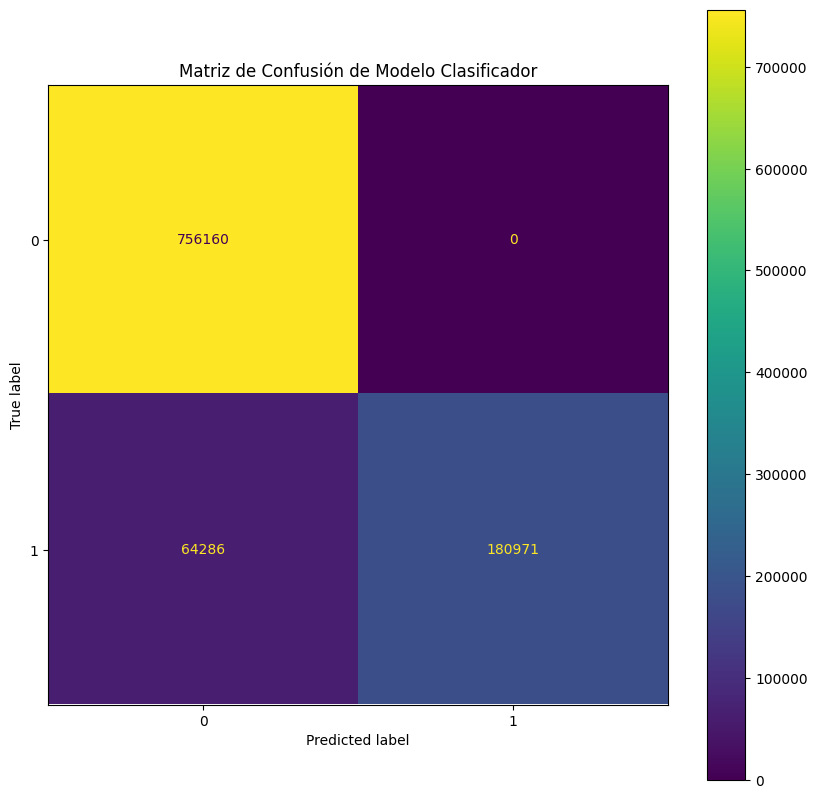

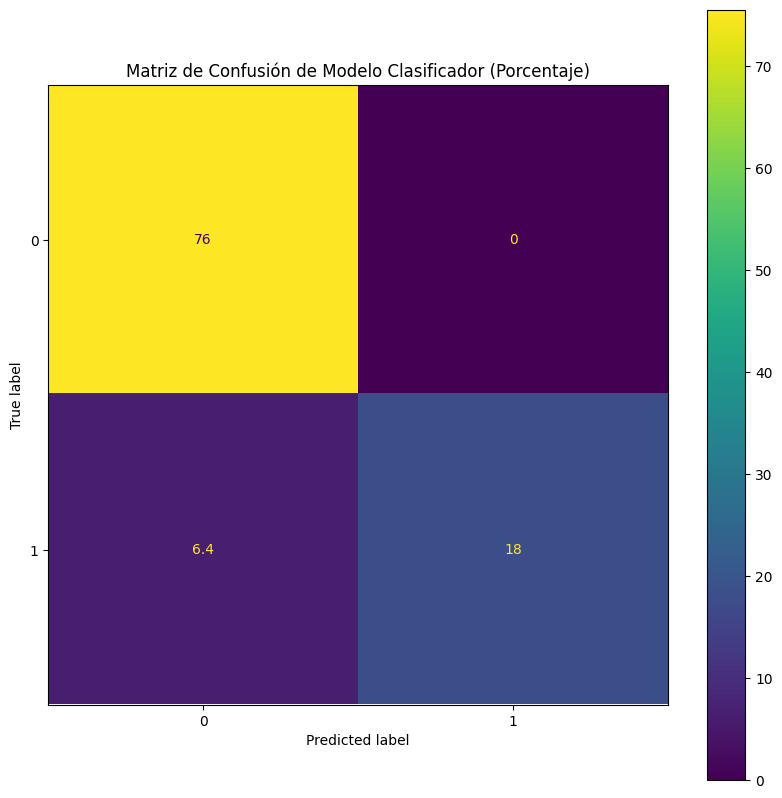

[[75.50900374  0.        ]
 [ 6.41950356 18.07149269]]
Accuracy: 0.9358049643654941
Precision: 0.9358049643654941
Recall: 0.9358049643654941
F1 Score: 0.9358049643654941


RandomForestClassifier(max_depth=40, n_estimators=200, random_state=42)

In [91]:
classificationRandomForest(X_train, y_train, X_test, y_test)

In [92]:
with open('X_resampled.pkl', 'wb') as f:
    pickle.dump(X_resampled, f)

In [93]:
with open('y_resampled.pkl', 'wb') as f:
    pickle.dump(y_resampled, f)